$$
\chi^{(2)}(2\omega_2) = \left(
    \frac{\left(\chi^{(2)}(\omega_1+\omega_2)\right)^4  g(\omega_1)}{\left(\chi^{(2)}(2\omega_1)\right)^2 g(\omega_2)}\right)^{1/2}
$$

$$
\chi^{(2)}(2\omega_1) = 1
$$


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.interpolate import interp1d, BSpline
from scipy.optimize import minimize
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 16

## Test for ZnO. $g$ generated from $\chi^{(2)}$ extracted from paper

In [39]:
ex_wl,chi2_expected = np.loadtxt('ZnO_chi2_Riporto.csv',delimiter=',')[::5].T
chi2_iu = interp1d(ex_wl,chi2_expected)
chi2_expected /= chi2_iu(1045)
plt.plot(ex_wl,chi2_expected, label='Chi2 (ZnO, Riporto)')
plt.legend()

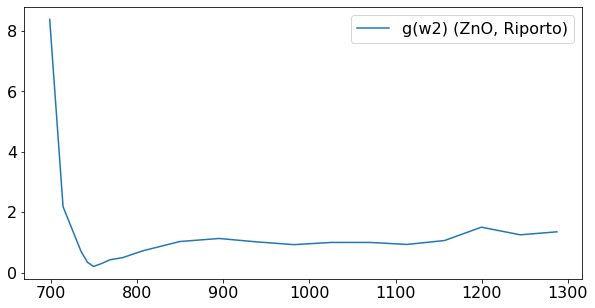

In [40]:
def g(ex_wl):
    return chi2_iu(2/(1/ex_wl+1/1045))**4/chi2_iu(ex_wl)**2  #/chi2_test(1045/2)**2
g0 = g(1045)
g_norm = g(ex_wl) / g0

plt.plot(ex_wl, g_norm, label='g(w2) (ZnO, Riporto)')
plt.legend()


### Assuming that initial $\chi^{(2)}_{init}\sim\sqrt{I_{2\omega_2}}$ 
*Note:* for test generating $\chi^{(2)}_{init}$ as expected $\chi^{(2)}$ from paper + strong noise

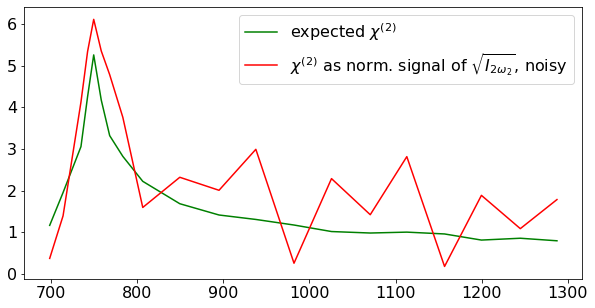

In [42]:
chi2_SHG_exp = chi2_expected+np.random.rand(len(chi2_expected))*3-1.
chi2_SHG_exp[chi2_SHG_exp<=0]=1e-1
plt.plot(ex_wl, chi2_expected,'g',label='expected $\chi^{(2)}$')
plt.plot(ex_wl, chi2_SHG_exp,'r',label='$\chi^{(2)}$ as norm. signal of $\sqrt{I_{2\omega_2}}$, noisy')
plt.legend()


## Minimizing function:
$$
f(\omega_1,\omega_2)=\chi^{(2)}(2\omega_2) - \left(
    \frac{\left(\chi^{(2)}(\omega_1+\omega_2)\right)^4  g(\omega_1)}{\left(\chi^{(2)}(2\omega_1)\right)^2 g(\omega_2)}\right)^{1/2}
$$
## with $\chi^{(2)}_{init}$ as initial guess in order to find corrected $\chi^{(2)}_{corr}$

In [45]:
def f(chi_2w2, ex_wl, g_norm):
    chi2_sfg = interp1d(ex_wl/2, chi_2w2)(1/(1/ex_wl+1/1045))
    res = ((chi_2w2 - chi2_sfg**2/g_norm**0.5)**2).sum()
    return res

In [46]:
result = minimize(f, x0=chi2_SHG_exp,
    args=(ex_wl, g_norm),
    #method='Nelder-Mead',
    method='CG',
    #method='Powell',
    #options={'maxfev':200000}
                 )
print(result)

     fun: 1.0580157141040697e-08
     jac: array([ 7.03525595e-06,  6.09191719e-07,  7.45020775e-07,  4.57271620e-07,
       -1.79846152e-07,  1.07685153e-07,  3.16622313e-07, -5.09289372e-07,
       -4.32792301e-06, -7.62457031e-06,  7.02291385e-06, -4.74598211e-06,
        1.75179573e-06,  5.82177110e-06,  2.76708306e-06,  5.73068300e-06,
       -2.94363240e-06,  3.89531714e-06,  3.54724804e-06,  4.86453585e-06])
 message: 'Optimization terminated successfully.'
    nfev: 30009
     nit: 803
    njev: 1429
  status: 0
 success: True
       x: array([1.4510718 , 2.38523643, 3.67686775, 5.09188302, 6.25934797,
       4.93632837, 3.89299022, 3.26616247, 2.53132371, 1.859325  ,
       1.52048726, 1.3716377 , 1.20417449, 1.02219841, 0.97030527,
       0.97673498, 0.92060753, 0.76960287, 0.80147311, 0.73556416])


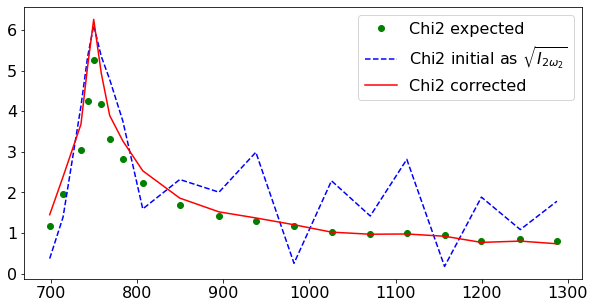

In [47]:
chi2_SHG_corrected = result.x
plt.plot(ex_wl, chi2_expected,'og',lw=1,label='Chi2 expected')
plt.plot(ex_wl, chi2_SHG_exp,'--b',label='Chi2 initial as $\sqrt{I_{2\omega_2}}$')

plt.plot(ex_wl, chi2_SHG_corrected,'r',label='Chi2 corrected')
plt.legend()

## Experimental data for ZnO NPs measured by microscope

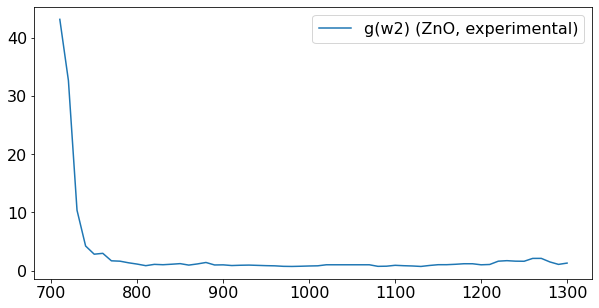

In [48]:
df = pd.read_csv('ZnO90-200nm_merged.csv')
df0 = df[df.centerIndex==0].copy()
mask = abs(df0.ex_wl-1045)<30
df0.loc[mask,['sfg','2w1','2w2']] = np.vstack([df0.loc[mask,['sfg','2w1','2w2']].mean()]*mask.sum())
g_exp = (df0['sfg']**2/df0['2w1']/df0['2w2']).values

g_exp_norm = abs(g_exp/interp1d(df0.ex_wl,g_exp)(1045))
chi2_exp_init = abs(df0['2w2'].values)**0.5
chi2_exp_init_norm = chi2_exp_init/interp1d(df0.ex_wl,chi2_exp_init)(1045)
plt.plot(df0.ex_wl, g_exp_norm, label='g(w2) (ZnO, experimental)')
plt.legend()


In [32]:
result = minimize(f, x0=chi2_exp_init_norm,
    args=(df0.ex_wl.values, g_exp_norm),
    method='Nelder-Mead',options={'maxfev':400000},
    #method='CG',
    #method='Powell',options={'maxfev':200000},
    
                 )
#print(result)

In [35]:
chi2_SHG_corrected = result.x
plt.plot(ex_wl, chi2_expected,'og',lw=1,label='$\chi^{(2)}$ expected')
plt.plot(df0.ex_wl, chi2_exp_init_norm,'--b',label='$\chi^{(2)}_{init}$ initial as $\sqrt{I_{2\omega_2}}$')

plt.plot(df0.ex_wl, chi2_SHG_corrected,'r',label='$\chi^{(2)}_{corr}$ corrected')
plt.legend()

## Experimental data for LN276 NPs measured by microscope

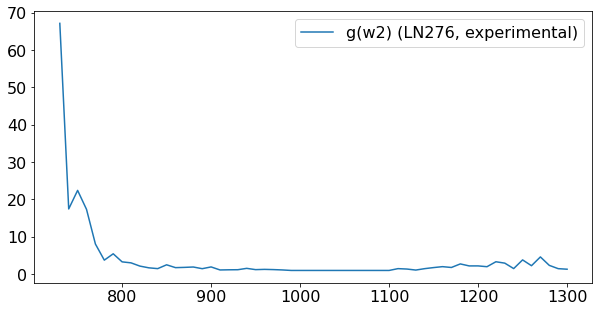

In [36]:
## df = pd.read_csv('LN276_2_merged.csv')
df0 = df[df.centerIndex==1].copy()[2:]
mask = abs(df0.ex_wl-1045)<60
df0.loc[mask,['sfg','2w1','2w2']] = np.vstack([df0.loc[mask,['sfg','2w1','2w2']].mean()]*mask.sum())
g_exp = (df0['sfg']**2/df0['2w1']/df0['2w2']).values

g_exp_norm = abs(g_exp/interp1d(df0.ex_wl,g_exp)(1045))
g_exp_norm[g_exp_norm<0.5]=1.5
chi2_exp_init = abs(df0['2w2'].values)**0.5
chi2_exp_init_norm = chi2_exp_init/interp1d(df0.ex_wl,chi2_exp_init)(1045)
plt.plot(df0.ex_wl, g_exp_norm, label='g(w2) (LN276, experimental)')
plt.legend()



In [37]:
result = minimize(f, x0=chi2_exp_init_norm,
    args=(df0.ex_wl.values, g_exp_norm),
    #method='Nelder-Mead',options={'maxfev':200000}
    method='CG',
    #method='Powell',options={'maxfev':200000}
    #method='SLSQP',
    
                 )
print(result)


     fun: 1.7298298862323513e-07
     jac: array([ 3.03240135e-08,  5.43475288e-07,  4.96532486e-08, -1.39010492e-06,
       -9.68730987e-07,  1.05502382e-06,  3.18856335e-06,  4.62349838e-07,
       -2.24279278e-06, -1.82451737e-06,  9.14719010e-07,  3.16436632e-06,
        4.51214088e-07,  3.42681362e-07,  1.28015171e-06,  5.98402632e-07,
        6.94150849e-07,  4.42255283e-07, -2.19501850e-07,  8.95118551e-06,
       -4.12500225e-06,  4.74511619e-07, -2.59796199e-06, -4.59440777e-06,
        4.83934129e-06,  8.05454725e-07, -1.01612611e-06,  4.20419084e-06,
       -2.37776599e-06, -4.89770311e-06, -3.91972716e-06,  1.20612827e-06,
        1.62424326e-06, -3.48156024e-06,  6.05689754e-07,  8.03831401e-07,
       -1.75623995e-08,  3.97660814e-06,  5.62857223e-06,  2.53066422e-06,
        6.42444411e-06,  5.66366054e-06,  2.34941006e-06,  2.48017732e-06,
        4.55643452e-06,  4.50254138e-06,  3.64784719e-06,  1.11556109e-06,
       -5.82290518e-08,  1.16301405e-06,  2.58474947e-06,

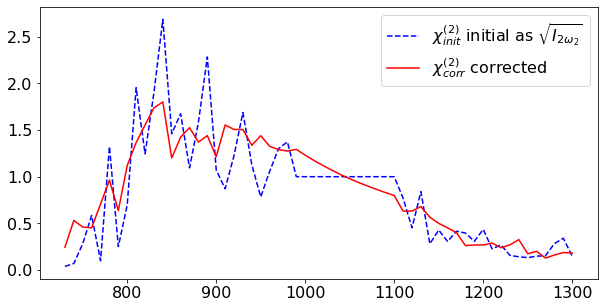

In [38]:
chi2_SHG_corrected = result.x
#plt.plot(ex_wl, chi2_expected,'og',lw=1,label='$\chi^{(2)}$ expected')
plt.plot(df0.ex_wl, chi2_exp_init_norm,'--b',label='$\chi^{(2)}_{init}$ initial as $\sqrt{I_{2\omega_2}}$')

plt.plot(df0.ex_wl, chi2_SHG_corrected,'r',label='$\chi^{(2)}_{corr}$ corrected')
plt.legend()